ここでは回帰とクラス分類の教師あり学習に焦点を充てる。    
今までの汎化性能の検証の例が下記。この章ではより頑健な汎化性能評価手法である交差検証を導入。    
またscoreメソッドで提供されるデフォルトR2より良い方法について議論する。

In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = make_blobs(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression().fit(X_train, y_train)

print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 0.88


# 交差検証

最もよく用いられる交差検証手法は`k分割交差検証`である．以下のような流れになる．

1. データをkつの同じサイズに分割する(fold)
2. 最初のモデルは最初の分割をテストセットとして使い，残りの(2~k)を訓練セットに使う
3. 次のモデルは分割2をテストセットとして使い，残りの(1,3~k)を訓練セットに使う
4. kつの精度を得る

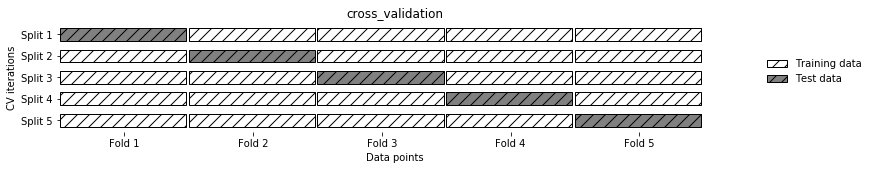

In [2]:
import mglearn
import matplotlib.pyplot as plt

mglearn.plots.plot_cross_validation()
plt.show()

## scikit-learnでの交差検証

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

#デフォルトで３分割の交差検証を行う
scores = cross_val_score(logreg, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96078431 0.92156863 0.95833333]


In [3]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [1.         0.96666667 0.93333333 0.9        1.        ]


90〜100%と分割間で精度のばらつきが比較的大きい。このモデルは訓練に用いられた特定の分割に強く依存していることを示唆しているが、データセットが小さすぎるせいかもしれない。

In [4]:
#交差検証の精度をまとめるには、一般的に平均値を用いる。
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.96


### 交差検証の利点

- メリット
    - モデルが最悪の場合と最良の場合にどの程度の性能を示すかが分かる
    - データをより効率的に使える
- デメリット
    - k個のモデルを訓練するため，単純な分割に比べてk倍遅くなる
    
データを多数に分割すると、モデルの訓練データセットに対する敏感さを知ることができる。    
irisデータでは精度が９０〜１００まで変動したが、このモデルでは最悪の場合と最良の場合の精度を示す。

### 層化k分割交差検証と他の戦略

テストデータセットをk/1を使うのは、うまく行くとは限らない。同じラベルが並んだデータなど。

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


上記のようなデータにたりして単純なk分割交差検証は弱い，そこで`層化k分割交差検証`を用いる。    
各分割内でのクラスの比率が全体の比率と同じようになるように分割する。クラスでグループ化して分割する。
一般的にクラス分類では層化交差検証の方が良い。

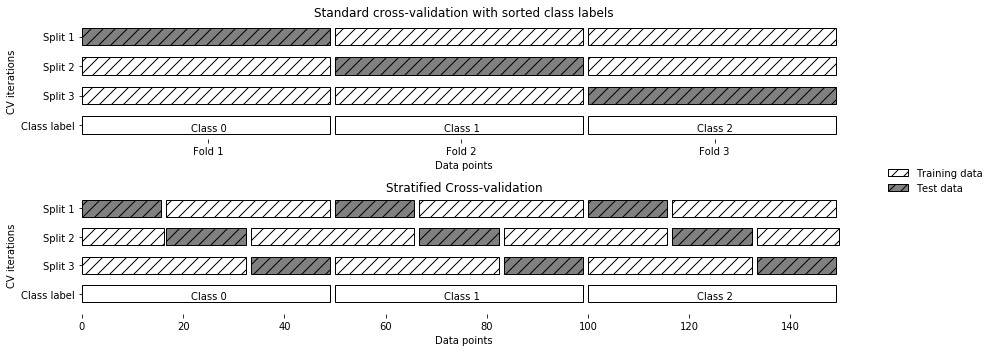

In [7]:
mglearn.plots.plot_stratified_cross_validation()
plt.show()

### 交差検証のより詳細な制御

ほとんどの場合は回帰にはk分割交差検証、クラス分類には層化k分割交差検証でうまく行く。しかし他の戦略をとりたい場合もある。例えば誰か別の人が実行した結果を再現するために、クラス分類にk分割交差検証を使わなければならない場合もある。これにはmodel_selectionモジュールからKFold分類器クラスをインポートし、分割数を与えて作成する。

In [6]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [7]:
print("Cross-validation scores:\n{}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[1.         0.93333333 0.43333333 0.96666667 0.43333333]


３分割の層化されていない状態で行うとひどいことになる。

In [8]:
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


データをシャッフルしても解決できる。

In [10]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0.9  0.96 0.96]


### 一つ抜き法、一つ抜き交差検証

別のよく用いられる交差検証手法。k分割交差検証の個々の分割が１サンプルしかないものだと考えれる。毎回テストセット中の１サンプルだけをテストセットとして検証する。大規模なデータセットには時間がかかるが、小さいデータセットには良い推定が可能になる。

In [11]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.95


### シャッフル分割交差検証

柔軟な交差検証。
`シャッフル分割交差検定`では毎回train_size個の点を選び出してテストサイズとする．これをn_iter回繰り返す．

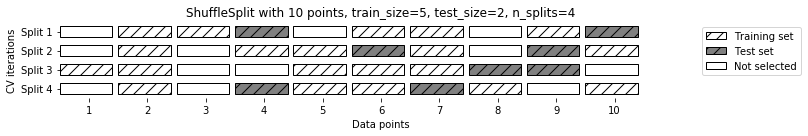

In [16]:
mglearn.plots.plot_shuffle_split()
plt.show()

データセットの50%を学習データセットに、50%をテストデータにして10回分割を繰り返す例。

In [17]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[ 0.88        0.94666667  0.92        0.96        0.90666667  0.86666667
  0.94666667  0.96        0.8         0.93333333]


テストデータが大きい場合に、データの一部のみを使うサブサンプリングも有用。

### グループ付き交差検証

訓練セットとテストセットを分離する際に分割してはならないグループを決めたいときに使う．医療データや顔画像から感情認識など、同じ人のデータがテストデータに出てこないようにする必要がある場合に使用する。

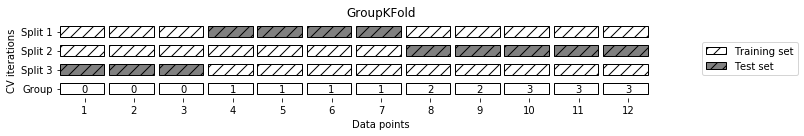

In [18]:
mglearn.plots.plot_group_kfold()
plt.show()

In [19]:
from sklearn.model_selection import GroupKFold

X, y = make_blobs(n_samples=12, random_state=0)

groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[ 0.75        0.8         0.66666667]


## まとめ

- KFold
- StratifiedKFold
- GroupKFold

を使っておけばだいたい大丈夫

In [11]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5)
k_fold
# for train_mask, test_mask in k_fold:
#     print(train_mask)

KFold(n_splits=5, random_state=None, shuffle=False)